In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

pm = pd.read_excel('PM.xlsx',index_col=0)
pm.index = pd.to_datetime(pm.index,format = "%Y%m")

factors = pd.read_csv('F-F_Research_Data_Factors.csv',skiprows = 3,index_col= 0)[942:1122].astype('float')
factors.index = pd.to_datetime(factors.index,format= '%Y%m')

In [2]:
factors

,Mkt-RF,SMB,HML,RF
2005-01-01,-2.76,-1.72,2.01,0.16
2005-02-01,1.89,-0.55,1.63,0.16
2005-03-01,-1.97,-1.35,2.14,0.21
2005-04-01,-2.61,-3.97,0.05,0.21
2005-05-01,3.65,2.80,-0.66,0.24
...,...,...,...,...
2019-08-01,-2.58,-2.40,-4.85,0.16
2019-09-01,1.43,-1.05,6.77,0.18
2019-10-01,2.06,0.24,-1.88,0.15
2019-11-01,3.87,0.91,-2.05,0.12


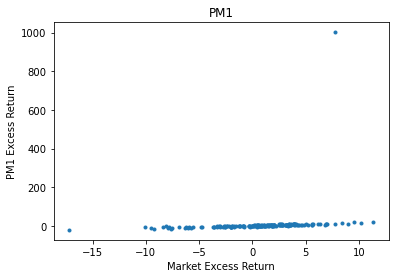

In [3]:
plt.xlabel("Market Excess Return")
plt.ylabel("PM1 Excess Return")
plt.plot(factors['Mkt-RF'],pm['PM1']-factors['RF'],'.')
plt.title('PM1');plt.show()

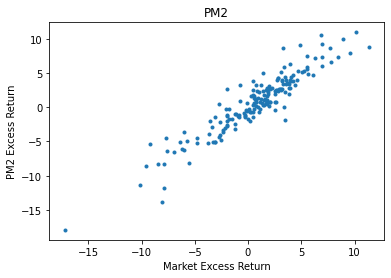

In [4]:
plt.xlabel("Market Excess Return")
plt.ylabel("PM2 Excess Return")
plt.plot(factors['Mkt-RF'],pm['PM2']-factors['RF'],'.')
plt.title('PM2');plt.show()

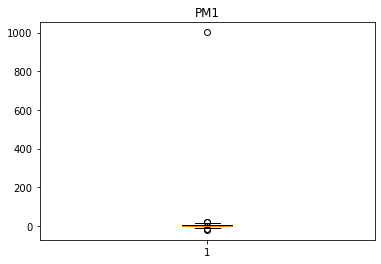

In [5]:
plt.boxplot(pm['PM1'])
plt.title('PM1');plt.show()

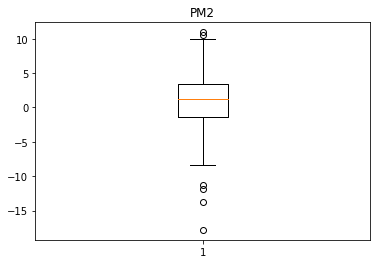

In [6]:
plt.boxplot(pm['PM2'])
plt.title('PM2');plt.show()

As the boxplot shows, PM1 has a significant outlier which has 1000% return for a single month. Compared with her returns on other months, I believe that this is due to data error and I will set the portoflio return of this month equaling to the market return

In [7]:
pm_corrected = pm.copy()
time = pd.to_datetime('20151001')
pm_corrected['PM1'][time] = factors['Mkt-RF'][time] + factors['RF'][time]

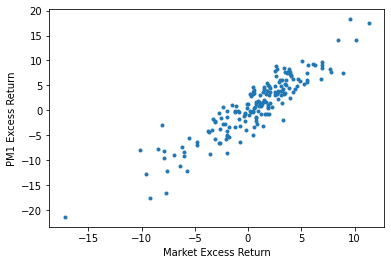

In [8]:
plt.xlabel("Market Excess Return")
plt.ylabel("PM1 Excess Return")
plt.plot(factors['Mkt-RF'],pm_corrected['PM1']-factors['RF'],'.')

In [9]:
pm_corrected

,PM1,PM2
2005-01-01,-6.323035,0.604917
2005-02-01,0.577468,2.323447
2005-03-01,-4.035636,-1.116219
2005-04-01,-6.273516,-1.919915
2005-05-01,7.790274,3.737481
...,...,...
2019-08-01,-1.310561,-4.681369
2019-09-01,-2.886594,5.117690
2019-10-01,3.880102,0.939580
2019-11-01,8.340928,3.512510


In [33]:
print("mean returns: %.4f, %.4f"%(pm_corrected['PM1'].mean(),pm_corrected['PM2'].mean()))

SR1 = (pm_corrected['PM1'] - factors['RF']).mean()*12 / ((pm_corrected['PM1'] - factors['RF']).std()*12**0.5)
SR2 = (pm_corrected['PM2'] - factors['RF']).mean()*12 / ((pm_corrected['PM2'] - factors['RF']).std()*12**0.5)


print("Sharpe Ratio: %.4f, %.4f"%(SR1, SR2))

def mdd(ts:pd.Series):
    returns = ts/100
    cum_value = (returns + 1).cumprod()
    return ((cum_value.cummax() - cum_value)/cum_value.cummax()).max()

def IR(track, bm):
    return (track-bm).mean()*12 / ((track-bm).std()*12**0.5)

print("Maximum Drawdone: %.4f, %.4f"%(mdd(pm_corrected['PM1']), mdd(pm_corrected['PM2'])))

print("information ratio: %.4f, %.4f"%(IR(pm_corrected['PM1'],factors['RF']+factors['Mkt-RF']),IR(pm_corrected['PM2'],factors['RF']+factors['Mkt-RF']) ))

mean returns: 1.1188, 0.8184
Sharpe Ratio: 0.5781, 0.5555
Maximum Drawdone: 0.5240, 0.5447
information ratio: 0.3621, -0.0061


In [61]:
excess_1 = (pm_corrected['PM1'] - factors['RF'])/100
excess_2 = (pm_corrected['PM2'] - factors['RF'])/100
x = sm.add_constant(factors[['Mkt-RF', 'SMB', 'HML']]/100)
res1 = sm.OLS(excess_1,x).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     6086.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.80e-177
Time:                        23:36:42   Log-Likelihood:                 668.00
No. Observations:                 180   AIC:                            -1328.
Df Residuals:                     176   BIC:                            -1315.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.256      0.798      -0.001       0.001
Mkt-RF         1.2911      0.012    108.028      0.000       1.268       1.315
SMB            0.8069      0.021     38.226      0.000       0.765       0.849
HML           -0.6875      0.018    -38.091      0.000      -0.723      -0.652
==============================================================================
Omnibus:                        0.092   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.955   Jarque-Bera (JB):                0.133
Skew:                          -0.053   Prob(JB):                        0.935
Kurtosis:                       2.920   Cond. No.                         48.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
res2 = sm.OLS(excess_2,x).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1442.
Date:                Mon, 29 Mar 2021   Prob (F-statistic):          1.35e-123
Time:                        23:36:57   Log-Likelihood:                 597.25
No. Observations:                 180   AIC:                            -1186.
Df Residuals:                     176   BIC:                            -1174.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.490      0.138      -0.000       0.002
Mkt-RF         0.9512      0.018     53.723      0.000       0.916       0.986
SMB           -0.1176      0.031     -3.761      0.000      -0.179      -0.056
HML            0.5336      0.027     19.954      0.000       0.481       0.586
==============================================================================
Omnibus:                        0.121   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.023
Skew:                           0.025   Prob(JB):                        0.989
Kurtosis:                       3.023   Cond. No.                         48.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is evidence for the second manager to outperform the market since she has significant alpha relative to the 3-factor model

The evidence for the first manager to outperform the 3-factor model is weaker both in statistical confidence and in absolute level

In [63]:
alpha_1 = res1.params['const']
alpha_2 = res2.params['const']
sigma_1 = ((res1.resid)**2).mean()**0.5
sigma_2 = ((res2.resid)**2).mean()**0.5
IR_1 = alpha_1 / sigma_1
IR_2 = alpha_2 / sigma_2
print("information ratio: %.4f, %.4f"%(IR_1,IR_2))

information ratio: -0.0197, 0.1146


## 3(c)

1. Which PM is better at beating the market? For this question we construct a portfolio that longs PM1 and short PM2, and check if the alpha is significantly positive or negative

In [64]:
long_short = pm_corrected['PM1'] - pm_corrected['PM2']
res3 = sm.OLS(long_short,x).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     734.8
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           2.96e-99
Time:                        23:37:07   Log-Likelihood:                -269.31
No. Observations:                 180   AIC:                             546.6
Df Residuals:                     176   BIC:                             559.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1122      0.083     -1.349      0.179      -0.276       0.052
Mkt-RF        33.9856      2.182     15.573      0.000      29.679      38.292
SMB           92.4489      3.854     23.987      0.000      84.843     100.055
HML         -122.1107      3.296    -37.051      0.000    -128.615    -115.606
==============================================================================
Omnibus:                        0.117   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.261
Skew:                          -0.026   Prob(JB):                        0.878
Kurtosis:                       2.821   Cond. No.                         48.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The alpha is not significant, thus we can not judge with statistical confidence that one PM is better than the other

2. Which can generate a higher Sharpe Ratio? For this question we use GMM method to test the hypothesis.

Assume $\mu_1, \mu_2, \sigma_2, \sigma_2$ being the mean and standard deviation for the excess return of two portfolio managers, the null hypothesis is:

$H_{0}:\left\{\frac{\mu_{1}}{\sigma_{1}}-\frac{\mu_{2}}{\sigma_{2}}=0\right\}$

Fisrtly we use GMM method to estimate parameters:

assume excess returns are: $(r^e_{1,1},r^e_{1,2},...,r^e_{1,T})$ and $(r^e_{2,1},r^e_{2,2},...,r^e_{2,T})$

$f_1(r^e_t,\theta) = r^e_{1} -\mu_1$

$f_2(r^e_t,\theta) = (r^e_{1} -\mu_1)^2 - \sigma_1 ^ 2$

$f_3(r^e_t,\theta) = r^e_{2} -\mu_2$

$f_4(r^e_t,\theta) = (r^e_{2} -\mu_2)^2 - \sigma_2 ^ 2$

Moment conditions:
$E\left[f\left(r^e_t, \theta\right)\right]=\left(\begin{array}{l} 0 \\0 \\ 0 \\ 0\end{array}\right)$

In finite sample:
$g_{T}(\theta)=\widehat{E}\left[f\left(x_{i}, \theta\right)\right]=\frac{1}{T} \sum_{i=1}^{T} f\left(x_{i}, \theta\right) = \left(\begin{array}{l} 
\frac{1}{T}\sum r^e_{1,t} -\mu_1 \\
\frac{1}{T}\sum(r^e_{1,t} -\mu_1)^2 - \sigma_1 ^ 2\\ 
\frac{1}{T}\sum r^e_{2,t} -\mu_2 \\
\frac{1}{T}\sum(r^e_{2,t} -\mu_1)^2 - \sigma_2 ^ 2\\
\end{array}\right)$

GMM minimizes $g_T^{\prime}g_T = [\frac{1}{T}(\sum r^e_{1,t} -\mu_1)] ^ 2 + [\frac{1}{T}[\sum(r^e_{1,t} -\mu_1)^2 - \sigma_1 ^ 2]]^2 + [\frac{1}{T}(\sum r^e_{2,t} -\mu_2)]^2 + [\frac{1}{T}[\sum(r^e_{2,t} -\mu_1)^2 - \sigma_2 ^ 2]]^2$

A particular solution that set the objective function to be zero is observable, which is $(\hat{\mu_1},\hat{\mu_2},\hat{\sigma_1},\hat{\sigma_2})$ where:
$$
\hat{\mu_1} = \frac{1}{T}\sum r^e_{1,t}\\
\hat{\sigma_1} = \frac{1}{T}[\sum(r^e_{1,t} -\hat{\mu_1})^2]\\
\hat{\mu_2} = \frac{1}{T}\sum r^e_{2,t}\\
\hat{\sigma_2} = \frac{1}{T}[\sum(r^e_{2,t} -\hat{\mu_2})^2]
$$

Since the objective function is nonnegative, this set of solution minimizes the objective function and thus is the GMM estimate of the parameters



In [65]:
excess_1 = (pm_corrected['PM1'] - factors['RF'])/100
excess_2 = (pm_corrected['PM2'] - factors['RF'])/100
m1 = excess_1.mean()
s1 = excess_1.std()
m2 = excess_2.mean()
s2 = excess_2.std()

$\hat{d} = \frac{\partial g_T(\theta)}{\partial \theta} =
\left[
\begin{array}{ll}
-1&0&0&0\\
\frac{2}{T}\sum(\hat{\mu_1} - r^e_{1,t}) = 0 & -2\hat{\sigma_1}&0&0 \\
0&0&-1&0\\
0&0&\frac{2}{T}\sum(\hat{\mu_2} - r^e_{1,t}) = 0& -2\hat{\sigma_2}\\
\end{array}
\right]
$


In [66]:
d = np.zeros((4,4))
d[0,0] = -1
d[1,1] = -2*s1
d[2,2] = -1
d[3,3] = -2*s2
d_t = np.transpose(d)
d

array([[-1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.12143169,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.08889909]])


$ S = E[f(x_t, \theta)f(x_t,\theta)^{\prime}]$ 

$ \hat{\Omega} = \frac{1}{T}(\hat{d^{\prime}}\hat{S^{-1}}\hat{d})$

In [67]:
import numpy as np
M = np.zeros(shape = (len(pm_corrected),4,4))
for t in range(len(pm_corrected)):
    f = np.zeros((4,1))
    r_1 = excess_1[t]
    r_2 = excess_2[t]
    f[0,0] = r_1 - m1
    f[1,0] = (r_1 - m1)**2 - s1**2
    f[2,0] = r_2 - m2
    f[3,0] = (r_2 - m2)**2 - s2**2
    M[t] = f@np.transpose(f)
S = M.mean(axis = 0)
S_inv = np.linalg.inv(S)
V = 1/len(pm_corrected) * np.linalg.inv(d_t@S_inv@d)

In [51]:
S

array([[ 3.66593405e-03, -1.13319511e-04,  2.02622850e-03,
        -6.25614771e-05],
       [-1.13319511e-04,  4.25623710e-05, -7.04105051e-05,
         1.50940144e-05],
       [ 2.02622850e-03, -7.04105051e-05,  1.96478569e-03,
        -6.23414316e-05],
       [-6.25614771e-05,  1.50940144e-05, -6.23414316e-05,
         1.46459391e-05]])

$\widehat{A}=\left.\frac{\partial h(\theta)}{\partial \theta^{\prime}}\right|_{\widehat{\theta}}=\left(\begin{array}{cccc}\frac{1}{\widehat{\sigma}_{1}} & -\frac{\widehat{\mu}_{1}}{\left(\widehat{\sigma}_{1}\right)^{2}} & -\frac{1}{\widehat{\sigma}_{2}} & \frac{\widehat{\mu}_{2}}{\left(\widehat{\sigma}_{2}\right)^{2}}\end{array}\right)$


$
\widehat{\operatorname{Var}}[h(\widehat{\theta})]=\left(\begin{array}{cccc}
\frac{1}{\widehat{\sigma}_{1}} & -\frac{\hat{\mu}_{1}}{\left(\widetilde{\sigma}_{1}\right)^{2}} & -\frac{1}{\hat{\sigma_2}} & \frac{\hat{\mu_{2}}}{\left(\hat{\sigma}_{2}\right)^{2}}
\end{array}\right)[\widehat{\Omega}]\left(\begin{array}{c}
\frac{1}{\widetilde{\sigma}_{1}} \\
-\frac{\mu_{1}}{\left(\widetilde{\sigma}_{1}\right)^{2}} \\
-\frac{1}{\bar{\sigma}_{2}} \\
\frac{\mu_{2}}{\left(\vec{\sigma}_{2}\right)^{2}}
\end{array}\right)
$

In [68]:
A = np.zeros((1,4))
A = np.array([[1/s1,-m1/s1**2,-1/s2,m2/s2**2]])

var_h = A@V@np.transpose(A)
sig_h = (var_h**0.5)[0,0]
h = m1/s1 - m2/s2
print(h/sig_h)

0.11835588317375431


3. Which can generate higher information ratio based on the 3-factor model?
We think about the time series of alpha for each PM, which is essentially $\alpha_{i,t} = R_{i, t}^{e}- (\beta_{i} R_{m, t}^{e}+\gamma_{i} R_{h m l, t}+\delta_{i} R_{s m b, t})$ for PM i. Compare with the regression function $R_{i, t}^{e}=\alpha_{i}+\beta_{i} R_{m, t}^{e}+\gamma_{i} R_{h m l, t}+\delta_{i} R_{s m b, t}+\epsilon_{i, t}$, its observable that we can have the following equation:

$$\alpha_{i,t} = \alpha_i + \epsilon_{i, t}$$

Which says, alpha for every term equals to the "predictable" or "mean" alpha and the rest unpredictable alpha. 

Mathematically speaking, $\alpha_i$ is the mean of $\alpha_{i,t}$, and $\sigma(\epsilon_{i,t})$ is the standard deviation of $\alpha_{i,t}$. Thus to compare information ratios we can use exactly the same method as comparing the Sharpe ratios, but replacing the excess return $r^e_{i,t}$ with the alpha return $\alpha_{i,t}$ (which is $R_{i, t}^{e}- (\beta_{i} R_{m, t}^{e}+\gamma_{i} R_{h m l, t}+\delta_{i} R_{s m b, t})$) from the regression result. You can still think this as the "excess return" but only using a different menchmark, where SR implies risk-free rate while IR implies 3-factor model.

In [69]:
alpha1 = res1.resid + res1.params['const']
alpha2 = res2.resid + res2.params['const']

m1 = alpha1.mean()
s1 = alpha1.std()
m2 = alpha2.mean()
s2 = alpha2.std()

d = np.zeros((4,4))
d[0,0] = -1
d[1,1] = -2*s1
d[2,2] = -1
d[3,3] = -2*s2
d_t = np.transpose(d)

M = np.zeros(shape = (len(pm_corrected),4,4))
for t in range(len(pm_corrected)):
    f = np.zeros((4,1))
    r_1 = excess_1[t]
    r_2 = excess_2[t]
    f[0,0] = r_1 - m1
    f[1,0] = (r_1 - m1)**2 - s1**2
    f[2,0] = r_2 - m2
    f[3,0] = (r_2 - m2)**2 - s2**2
    M[t] = f@np.transpose(f)
S = M.mean(axis = 0)
S_inv = np.linalg.inv(S)
V = 1/len(pm_corrected) * np.linalg.inv(d_t@S_inv@d)

A = np.array([[1/s1,-m1/s1**2,-1/s2,m2/s2**2]])

var_h = A@V@np.transpose(A)
sig_h = (var_h**0.5)[0,0]
h = m1/s1 - m2/s2
print(h/sig_h)

-0.20706750016859493


In [70]:
A

array([[ 168.55823502,    3.31435277, -113.77237657,   13.0074956 ]])

In [60]:
(m1,s1,m2,s2)

(-0.00011665377083729221,
 0.0059326677210013905,
 0.001004893478095318,
 0.008789479750319717)